In [1]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import numpy as np
import bbknn

%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../../figures/SI/batch_effects"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg", ".pdf"]

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

# Set Scanpy figure parameters
sc.set_figure_params(
    dpi_save=150, frameon=False,
    vector_friendly=True, fontsize=6, figsize=(2.25, 2.25),
    format='pdf', transparent=True
)

# Set Scanpy figure directory
sc.settings.figdir = output_dir

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%run ../../scripts/global_plot_settings.py

# Set Seaborn style
sns.set_style("ticks")

# Use custom Matplotlib style
plt.style.use('../../scripts/bursa.mplstyle')


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = "../../../data/gex/all_cells.h5ad.gz"
adata = sc.read_h5ad(filename, backed='r+')

adata.obs['HT_library'] = adata.obs['sample_uid'].str.contains("HT")
adata.obs['data_from_this_study'] = adata.obs.sample_uid.str.contains('TBd')
adata.obs['frozen'] = adata.obs.sample_uid.str.contains('frozen')

# DownSample Full DataSet to ~40K cells

In [3]:
# Calculate the size of each group with observed=True to adopt the future default and silence the warning
group_sizes = adata.obs.groupby("sample_uid", observed=True).size()
large_groups = group_sizes[group_sizes > 700].index

# Use the mask to filter adata.obs
filtered_data = adata.obs.loc[adata.obs['sample_uid'].isin(large_groups)].copy()

# Remove unused categories from the 'donor_tissue' column and ensure the data type is consistent
filtered_data['sample_uid'] = filtered_data['sample_uid'].astype('category')
filtered_data['sample_uid'] = filtered_data['sample_uid'].cat.remove_unused_categories()

# Now perform the groupby with observed=True and sample
sampled_data = filtered_data.groupby("sample_uid", observed=True).sample(n=500, replace=False)


In [4]:
# move subset data to memory
ad = adata[adata.obs.index.isin(sampled_data.index)].to_memory()

In [6]:
print(f"{ad.shape[0]} in the downsampled dataset")
ad.obs['HT_library'] = ad.obs['sample_uid'].str.contains("HT")
ad.obs['data_from_this_study'] = ad.obs.sample_uid.str.contains('TBd')
ad.obs['frozen'] = ad.obs.sample_uid.str.contains('frozen')

41000 in the downsampled dataset


In [7]:
# define_technical_variables to plot on UMAP
technical_variables = ['log1p_total_counts', "data_from_this_study", "donor", "tissue", "frozen", "Immune_All_Low_predicted_labels", "Immune_All_High_predicted_labels"]

In [8]:
space = "X_scVI_all"
sc.pp.neighbors(ad, use_rep=space)
sc.tl.umap(ad)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


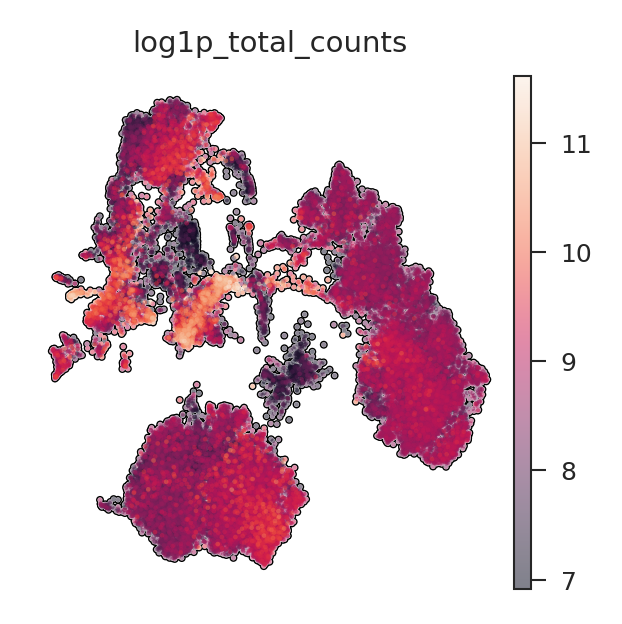

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


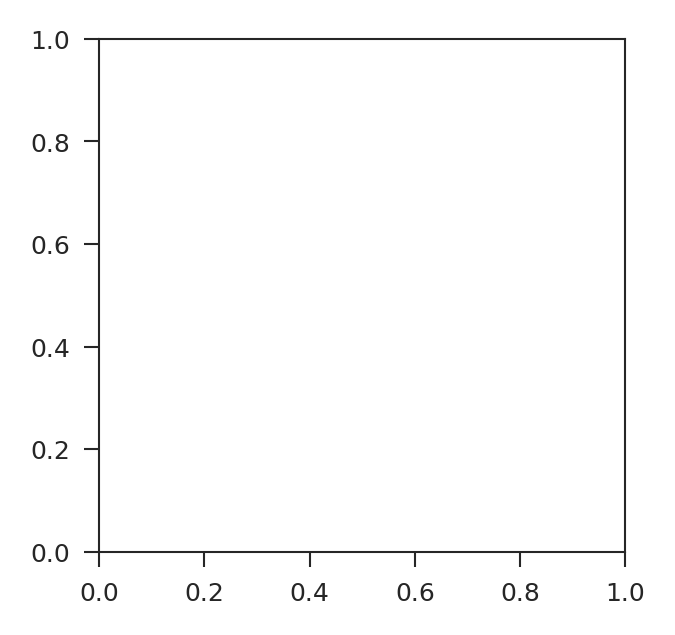

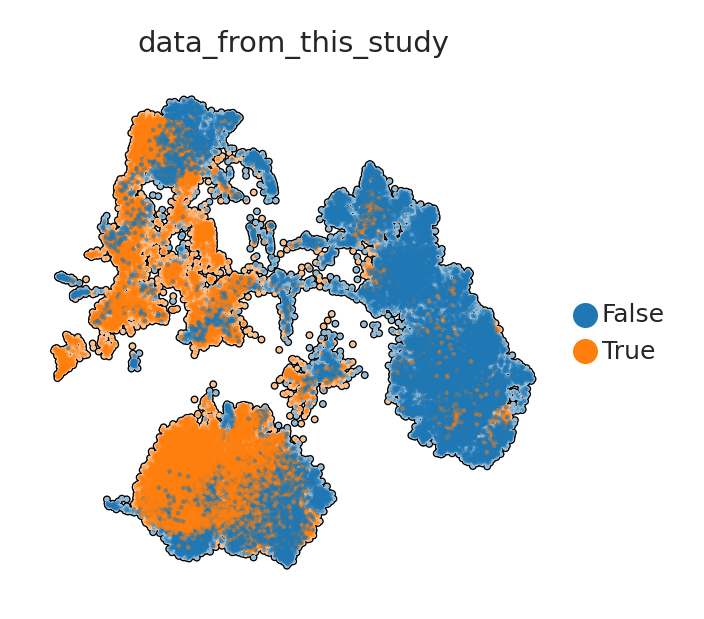

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


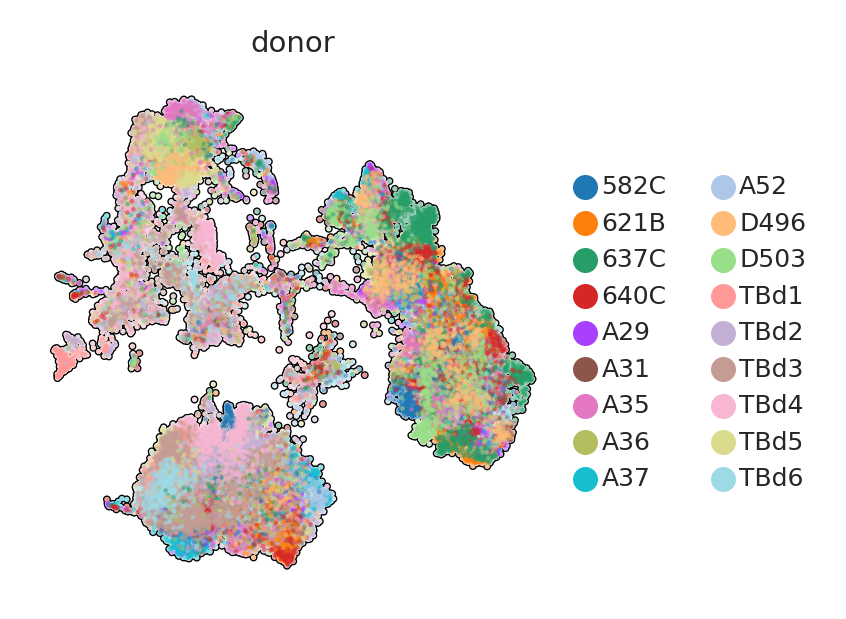

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


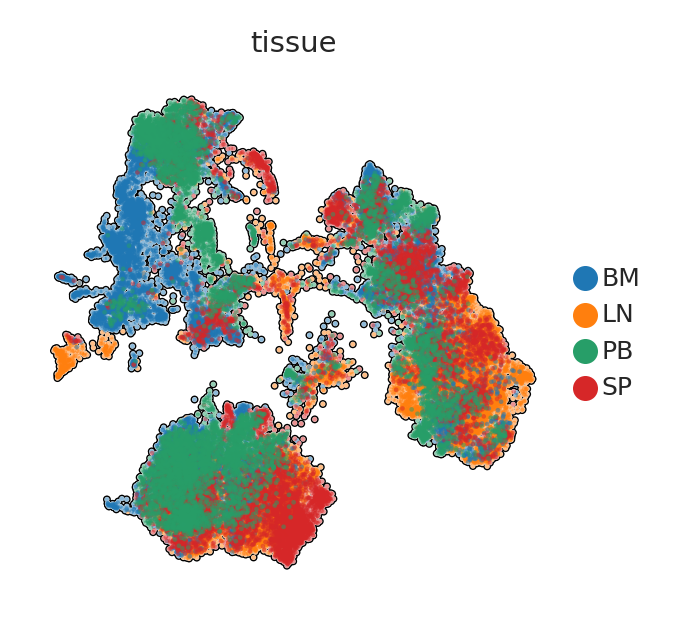

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


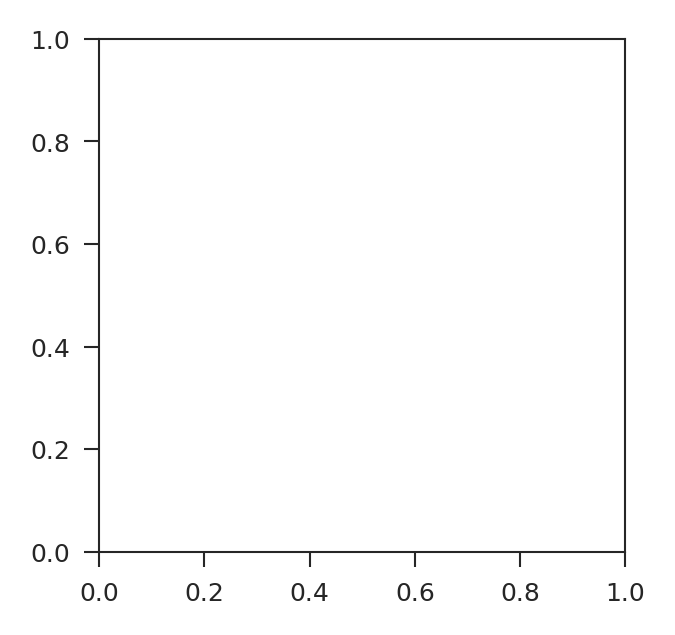

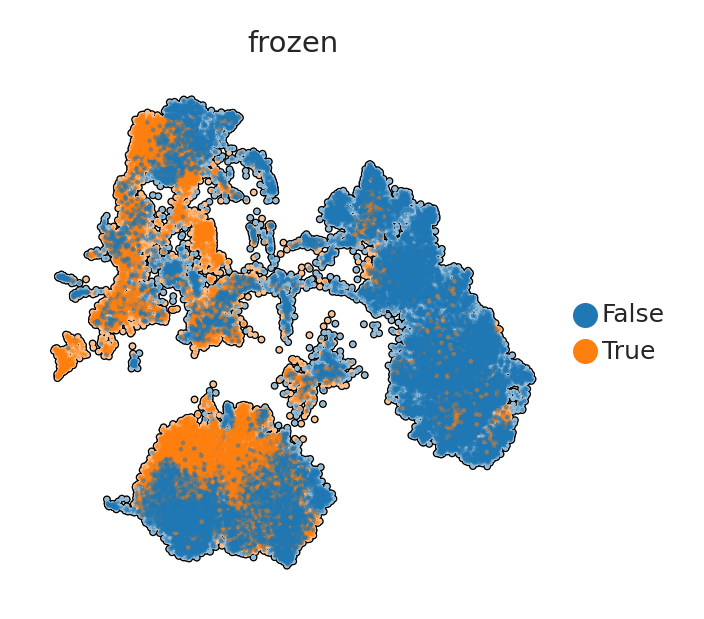

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


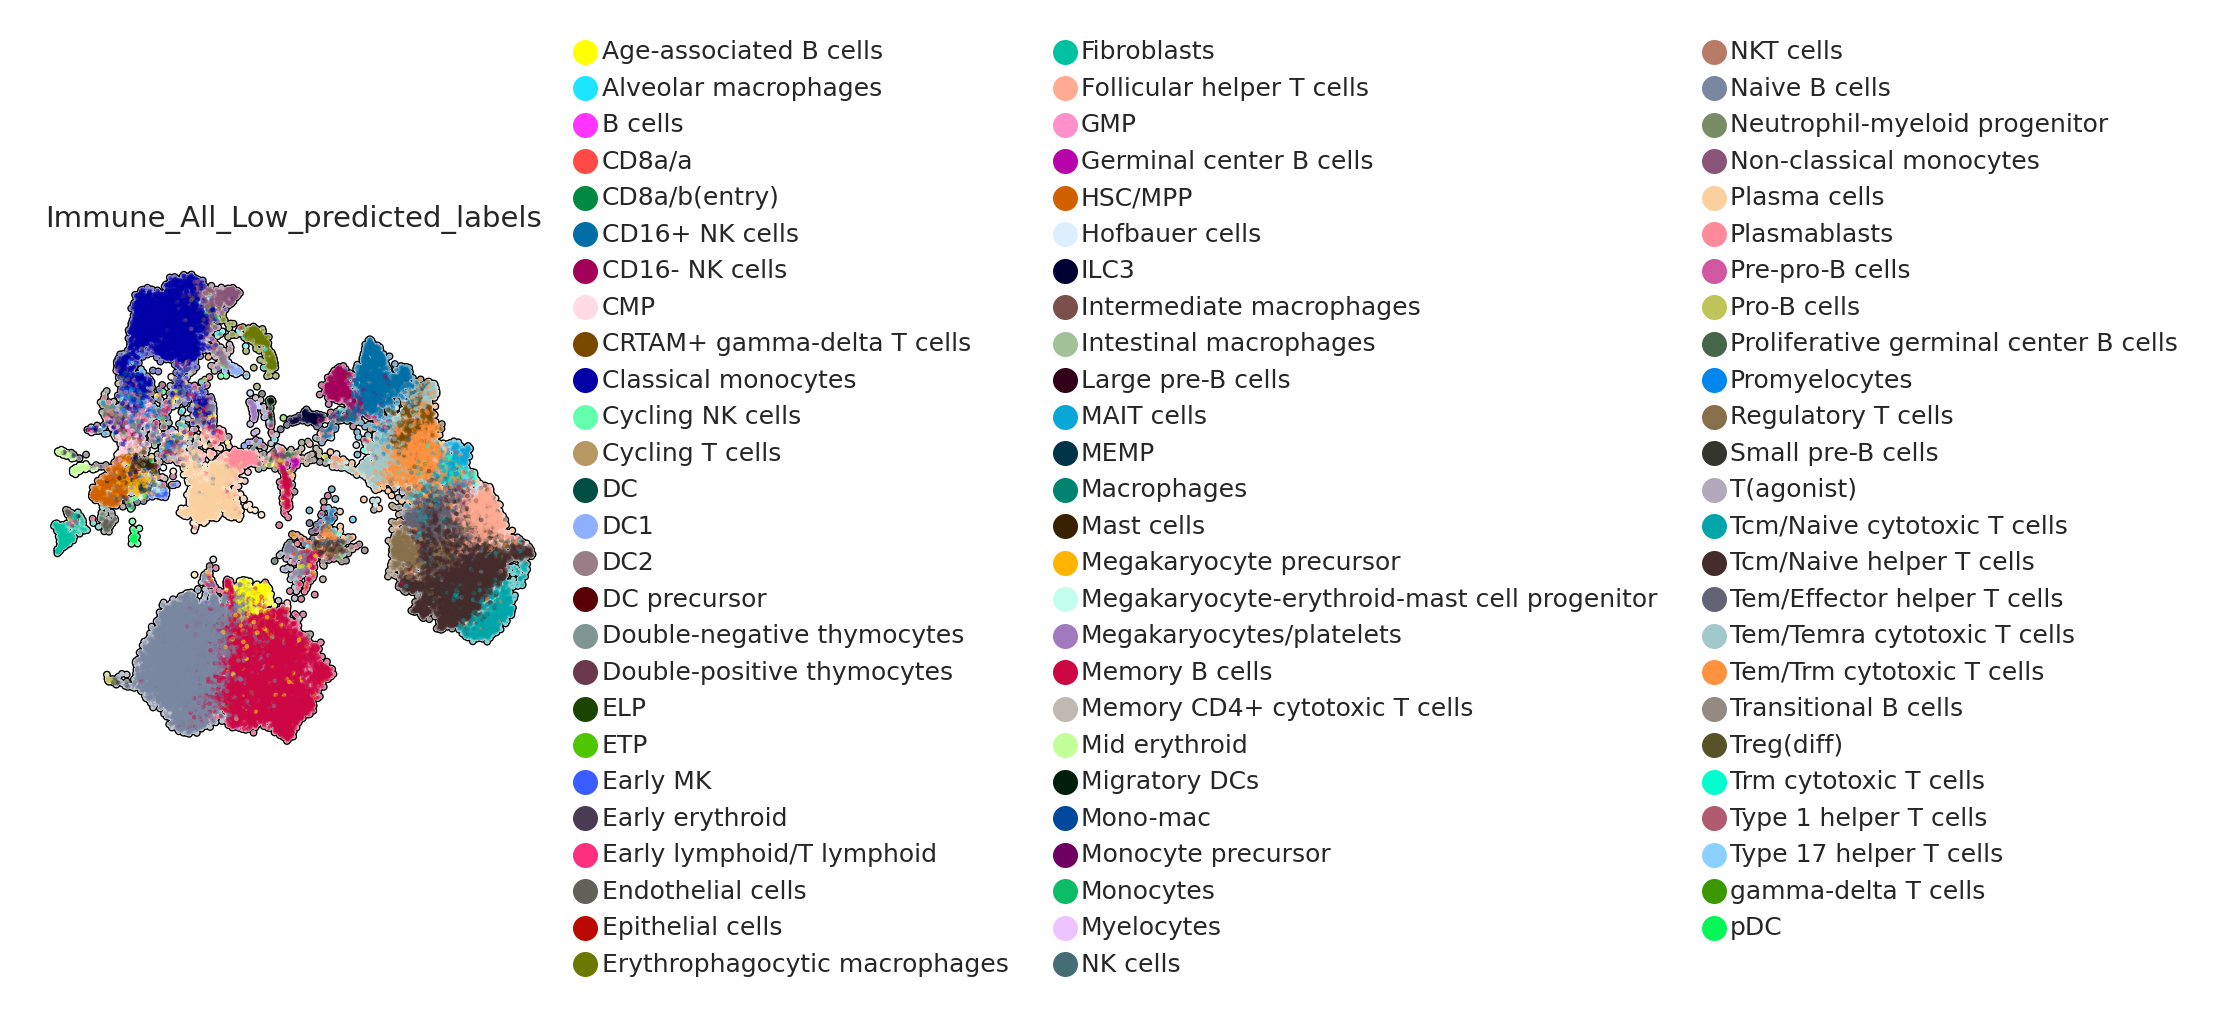

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


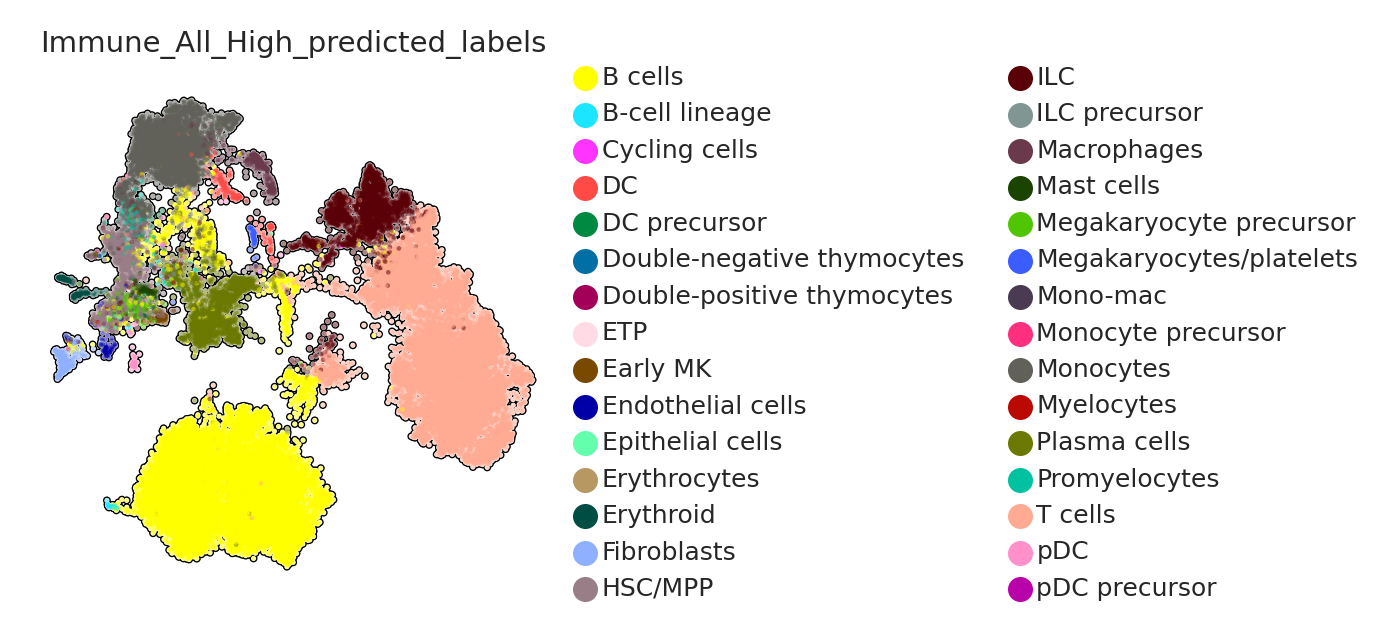

In [9]:
for var in technical_variables:
    try:
        sc.pl.umap(ad, color=var, size=5, alpha=0.5, add_outline=True, save=f"{var}_umap_{space}.png")
    except TypeError as e:
        if "The numpy boolean negative, the `-` operator, is not supported" in str(e):
            # Convert the categorical variable to string
            ad.obs[var] = ad.obs[var].astype(str)
            sc.pl.umap(ad, color=var, size=5, alpha=0.5, add_outline=True, save=f"{var}_umap_{space}.png")
        else:
            # If it's a different TypeError, re-raise it
            raise

In [10]:
def compute_silhouette_scores(ad, n_obs=10000, rep="X_umap_bbknn", cluster_label='Immune_All_Low_predicted_labels'):
    # Subsample ad for prototyping purposes
    sub = sc.pp.subsample(ad, n_obs=n_obs, copy=True)
    # Get the cluster labels and the UMAP coordinates
    cluster_labels = sub.obs[cluster_label]
    X = sub.obsm[rep]
    color_dict = dict(zip(sub.obs[cluster_label].unique().sort_values(), sub.uns[f'{cluster_label}_colors']))
    
    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    return silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X


def plot_silhouette_scores(silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X, ax, key, show_legend=False):
    # The silhouette coefficient can range from -1 to 1
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, len(X) + (len(np.unique(cluster_labels)) + 1) * 10])

    y_lower = 10
    for i, label in enumerate(np.unique(cluster_labels)):
        # Aggregate the silhouette scores for samples belonging to each cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == label]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = color_dict[label]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        y_lower = y_upper + 10

    #ax.set_title(f"NN Graph with {key} as basis")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel(f"Celltypist Labels")

    # The vertical line for the average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])

In [11]:
use_reps = {"PCA":"X_pca", "scVI":"X_scVI_all", "bbknn":"bbknn"}
 # Filter out small clusters
cluster_sizes = ad.obs['Immune_All_Low_predicted_labels'].value_counts()
large_clusters = cluster_sizes[cluster_sizes >= 250].index
filtered_ad = ad[ad.obs['Immune_All_Low_predicted_labels'].isin(large_clusters)].copy()
filtered_ad.obs.Immune_All_Low_predicted_labels.cat.remove_unused_categories()

AAACCTGGTGCCTGGT-1                           Naive B cells
AAACGGGGTTAAGAAC-1                          Memory B cells
AAAGCAACAGACACTT-1                           Naive B cells
AAAGTAGCATGGTCTA-1                          Memory B cells
AAATGCCCACACATGT-1                          Memory B cells
                                          ...             
CZINY-0112_TCGGTCTCACTATCCC            Classical monocytes
CZINY-0112_TCTACCGTCGGAATTC       Tcm/Naive helper T cells
CZINY-0112_TCTGGCTAGTGCGCTC    Tem/Temra cytotoxic T cells
CZINY-0112_TGGGCTGCAAGAGTAT    Tcm/Naive cytotoxic T cells
CZINY-0112_TTCGCTGAGGACGCTA            Classical monocytes
Name: Immune_All_Low_predicted_labels, Length: 38382, dtype: category
Categories (20, object): ['Age-associated B cells', 'CD16+ NK cells', 'CD16- NK cells', 'CRTAM+ gamma-delta T cells', ..., 'Tcm/Naive helper T cells', 'Tem/Effector helper T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells']

In [12]:
def compute_silhouette_scores(ad, n_obs=10000, rep="X_umap_bbknn", cluster_label='Immune_All_Low_predicted_labels'):
    # Subsample ad for prototyping purposes
    sub = sc.pp.subsample(ad, n_obs=n_obs, copy=True)
    # Get the cluster labels and the UMAP coordinates
    cluster_labels = sub.obs[cluster_label]
    X = sub.obsm[rep]
    color_dict = dict(zip(sub.obs[cluster_label].unique().sort_values(), sub.uns[f'{cluster_label}_colors']))
    
    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    return silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X


for k, val in use_reps.items():
    ### Umaps using scVI latent space
    if k == "bbknn":
        bbknn.bbknn(filtered_ad, batch_key='donor_tissue')
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']
    else:
        sc.pp.neighbors(filtered_ad, use_rep=val)
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']

    # Ensure the key for UMAP coordinates is correctly formatted
    umap_key = f'X_umap_{k}'

    # remove small Immune_All_High_predicted_labels clusters

    # Compute silhouette scores
    silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X = compute_silhouette_scores(
        filtered_ad, n_obs=5000, rep=umap_key, cluster_label='Immune_All_Low_predicted_labels'
    )

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    
    # Plot UMAP
    sc.pl.embedding(filtered_ad, basis=umap_key, color='Immune_All_Low_predicted_labels', size=5, alpha=0.5, add_outline=True, 
                    ax=axes[1], show=False)
    axes[1].set_title(f"UMAP using {k}")

    # Plot silhouette scores
    plot_silhouette_scores(silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X, axes[0], k, show_legend=True)
    axes[0].set_title(f"Silhouette Scores using {k}")

    plt.tight_layout()

    # Save the figure
    output_path = pathlib.Path(output_dir) / k
    output_path.mkdir(parents=True, exist_ok=True)
    fig_path = output_path / f"{k}_embedding_and_silhouette.eps"
    fig.savefig(fig_path, **savefig_args)

    plt.close(fig)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michae

In [13]:
label = 'donor'

for k, val in use_reps.items():
    ### Umaps using scVI latent space
    if k == "bbknn":
        bbknn.bbknn(filtered_ad, batch_key='donor_tissue')
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']
    else:
        sc.pp.neighbors(filtered_ad, use_rep=val)
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']

    # Ensure the key for UMAP coordinates is correctly formatted
    umap_key = f'X_umap_{k}'

    # remove small Immune_All_High_predicted_labels clusters

    # Compute silhouette scores
    silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X = compute_silhouette_scores(
        filtered_ad, n_obs=5000, rep=umap_key, cluster_label=label
    )

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    
    # Plot UMAP
    sc.pl.embedding(filtered_ad, basis=umap_key, color=label, size=5, alpha=0.5, add_outline=True, 
                    ax=axes[1], show=False)
    axes[1].set_title(f"UMAP using {k}")

    # Plot silhouette scores
    plot_silhouette_scores(silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X, axes[0], k, show_legend=True)
    axes[0].set_title(f"Silhouette Scores using {k}")

    plt.tight_layout()

    # Save the figure
    output_path = pathlib.Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    fig_path = output_path / f"{k}_{label}_embedding_and_silhouette.png"
    fig.savefig(fig_path, **savefig_args)

    plt.close(fig)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWa

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


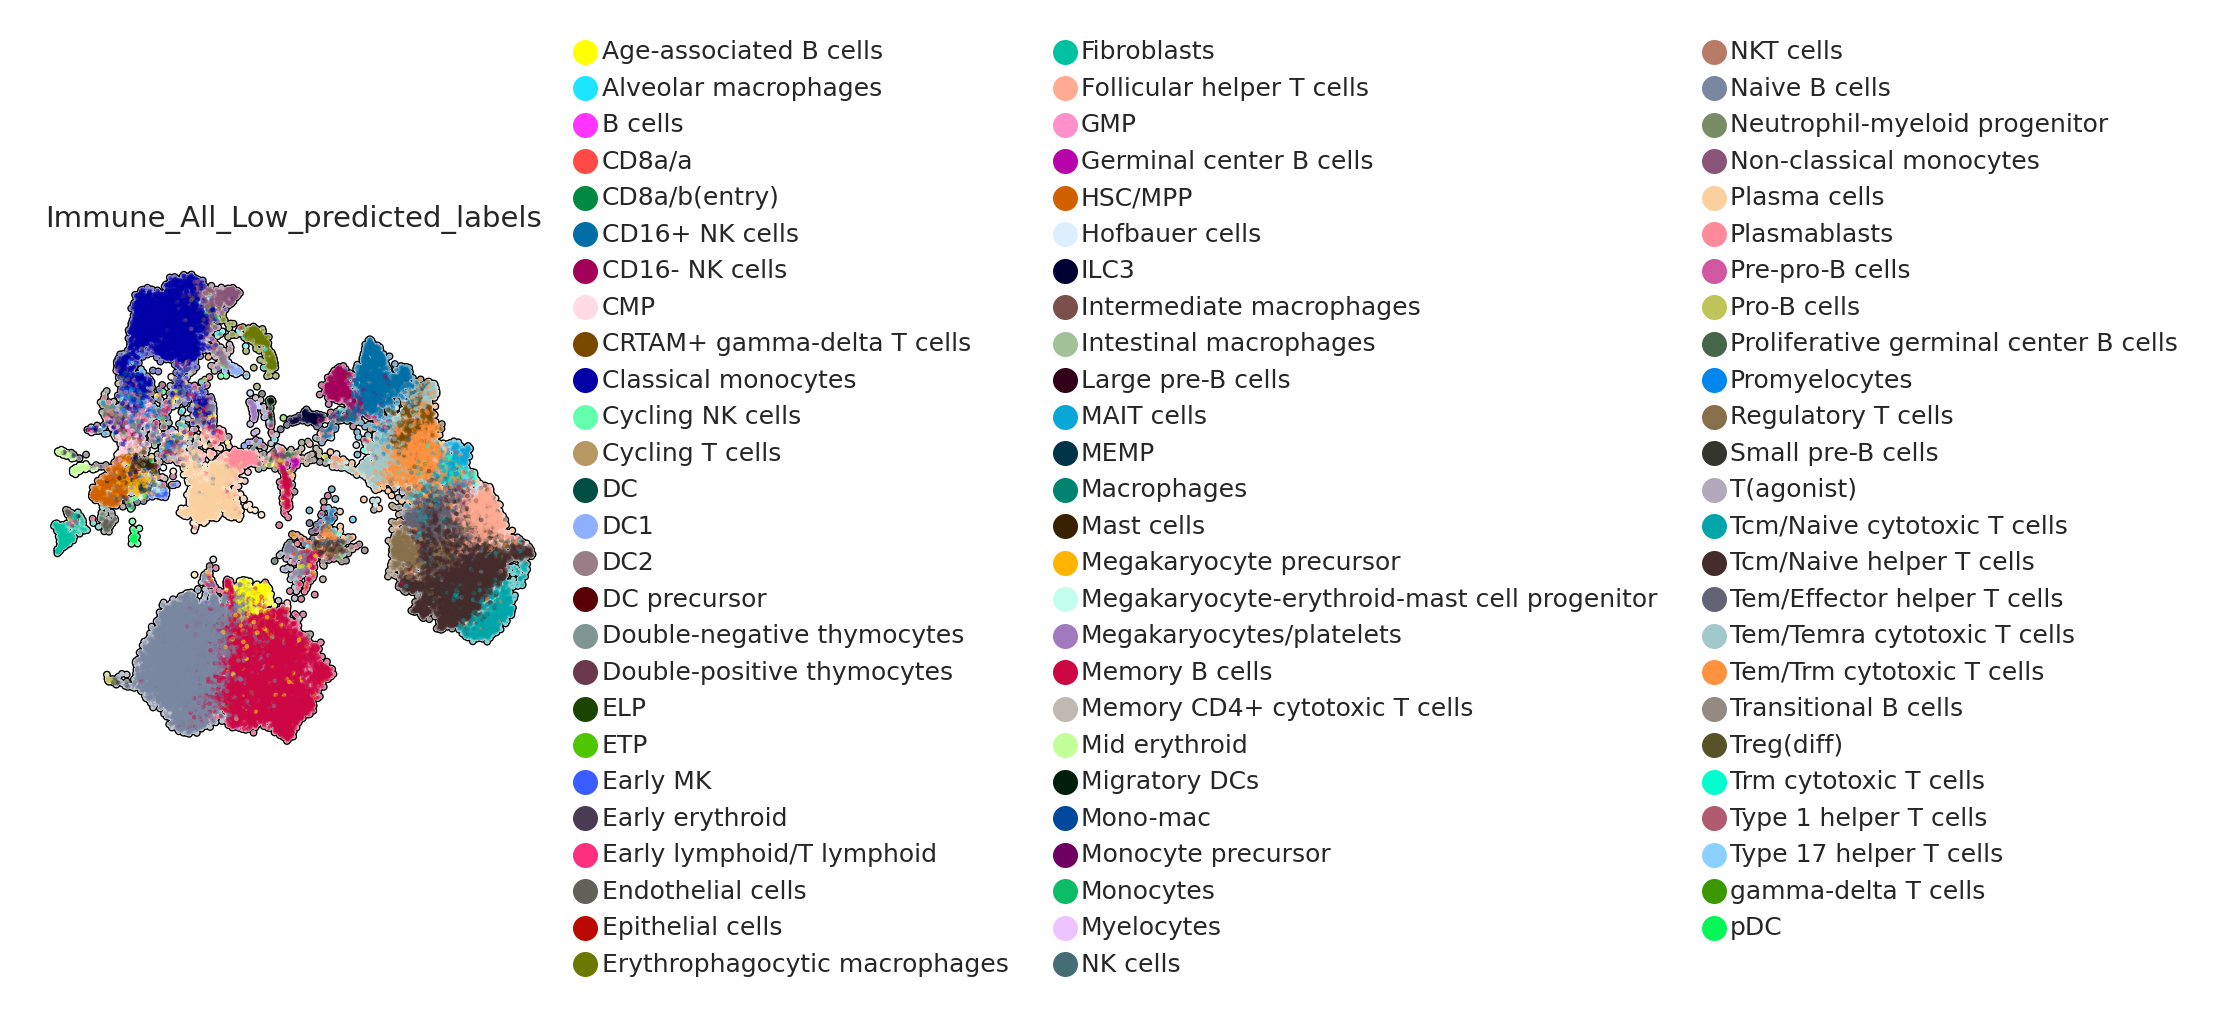

In [14]:
sc.pp.neighbors(ad, use_rep='X_scVI_all')
sc.tl.umap(ad)
sc.pl.umap(ad, color='Immune_All_Low_predicted_labels', size=5, alpha=0.5, add_outline=True)

In [15]:
ad.obs['HT_library'] = ad.obs['HT_library'].astype(str)

In [16]:
for k, val in use_reps.items():
    ### Umaps using scVI latent space
    if k == "bbknn":
        bbknn.bbknn(filtered_ad, batch_key='donor_tissue')
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']
        basis_name = "BBKNN"
    else:
        sc.pp.neighbors(filtered_ad, use_rep=val)
        sc.tl.umap(filtered_ad)
        filtered_ad.obsm[f'X_umap_{k}'] = filtered_ad.obsm['X_umap']
        basis_name = k.upper()

    # Ensure the key for UMAP coordinates is correctly formatted
    umap_key = f'X_umap_{k}'

    # Save UMAP plots for each technical variable
    for var in technical_variables:
        fig, ax = plt.subplots(figsize=(2.25, 2.25))
        sc.pl.embedding(filtered_ad, basis=umap_key, color=var, size=5, alpha=0.5, add_outline=True, 
                        ax=ax, show=False, title=f"UMAP ({basis_name})")
        plt.tight_layout()
        fig.savefig(f"{output_dir}/{var}_umap_{basis_name}.png", **savefig_args)
        plt.close(fig)

    # Compute silhouette scores
    silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X = compute_silhouette_scores(
        filtered_ad, n_obs=5000, rep=umap_key, cluster_label='Immune_All_Low_predicted_labels'
    )

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    
    # Plot UMAP
    sc.pl.embedding(filtered_ad, basis=umap_key, color='Immune_All_Low_predicted_labels', size=5, alpha=0.5, add_outline=True, 
                    ax=axes[1], show=False, title=f"UMAP ({basis_name})")

    # Plot silhouette scores
    plot_silhouette_scores(silhouette_avg, sample_silhouette_values, cluster_labels, color_dict, X, axes[0], k, show_legend=True)
    axes[0].set_title(f"Silhouette Scores ({basis_name})")

    plt.tight_layout()

    # Save the figure
    output_path = pathlib.Path(output_dir) / basis_name.lower()
    output_path.mkdir(parents=True, exist_ok=True)
    fig_path = output_path / f"{basis_name.lower()}_embedding_and_silhouette.eps"
    fig.savefig(fig_path, **savefig_args)

    plt.close(fig)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.p